In [18]:
#from Final import FileFinder
#from Final import TableJoiner
import glob
import geopandas as gpd
import pandas as pd
import mapclassify
from pyproj import CRS
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
import contextily as ctx
import mplleaflet
import folium
import builtins
%matplotlib inline

In [25]:
#define function for the ComparisonTool
def ComparisonTool(YKR_ID, Comparison, Comparisontype, grid, output_folder):
    """Compare travel times or travel distances between two different travel modes. For example, compare rush
    hour travel times by public transport and car based on columns pt_r_t and car_r_t, and rush hour travel
    distances based on columns pt_r_d and car_r_d. Given comparisons need to be in a list of two travel modes.
    In the calculation, the first travel mode is always subtracted by the last one: travelmode1 - travelmode2
    according to the order in which the travel modes were listed. The tool saves outputs as new shapefile.
    Accepted travel modes are the same ones that are found in the actual TravelTimeMatrix file (walking, biking,
    public transport and car)."""
    
    #Assert the given types are following
    #Comparison = single string or list of two strings specifying travel modes (four possible travel modes)
    
    #YKR_ID = string, integer or list of strings or integers
    assert type(YKR_ID) == str or type(YKR_ID) == int or type(YKR_ID) == builtins.list, 'YKR_ID variable must be a string, integer or a list of strings or integers'
    if type(YKR_ID) == builtins.list:
        for index in YKR_ID:
            assert type(index) == str or type(index) == int, 'The variables in a given list need to be in string or integer format'
    
    assert type(Comparison) == builtins.list or type(Comparison) == str, 'For comparisons, the comparison variable needs to be a list of two travel modes. For example ["car", "bike"]. The list items need to be in string format. For a travel time map of a single travelmode, the comparison variable needs to be a signle string. Possible travel modes are "car", "biking", "public transport" and "walking"'
    
    if type(Comparison) == str:
        assert Travelmode == 'car' or Travelmode == 'public transport' or Travelmode == 'walking' or Travelmode == 'biking', 'Travel mode needs to be either "car", "public transport", "walking" or "biking"'
    
    if type(Comparison) == builtins.list:
        assert len(Comparison) == 2, 'The list of travel modes can only contain two variables'
        assert Comparison[0] != Comparison[1], 'The variables in Comparison list must be different traveltypes'
        for Travelmode in Comparison:
            assert Travelmode == 'car' or Travelmode == 'public transport' or Travelmode == 'walking' or Travelmode == 'biking', 'Travel mode needs to be either "car", "public transport", "walking" or "biking"'
    
    #comparisontype = single string of two options
    assert type(Comparisontype) == str, 'Comparison type variable needs to be a string. Choose either "time" or "distance"'
    assert Comparisontype == 'time' or Comparisontype == 'distance', 'Comparison type needs to be either "time" or "distance"'
    
    #grid = geodataframe
    assert isinstance(grid, gpd.GeoDataFrame), 'grid variable needs to be a geodataframe'
    
    #output folder = string
    assert type(output_folder) == str, 'output folder needs to be in string format.'
    
    
    #This step can either be done outside the visualizer function or within it. I chose to add it within the function
    Filelist = FileFinder(YKR_ID = YKR_ID, foldername = 'data')
    TableJoiner(Filelist, grid)
    
    #if the filelist is empty, no travel time data could be found
    assert len(Filelist) >= 1, 'Could not find travel time data from the data folder. Check the input formats and data folder of Filefinder function'
    
    #If the given IDs are a list of IDs
    for index in Filelist:
        split = Filelist[0].split('_')
        split = split[2].split('.')
        filename = 'data/' + split[0] + '.shp'
        map_data = gpd.read_file(filename)
        
        fig, ax = plt.subplots(figsize=(10,5))
            
        walk_time = map_data['walk_t']
        walk_distance = map_data['walk_d']
            
        car_time = map_data['car_r_t']
        car_distance = map_data['car_r_d']
            
        pt_time = map_data['pt_r_t']
        pt_distance = map_data['pt_r_d']
            
        """bike_time = map_data['bike_s_t']
        bike_distance = map_data['bike_d']"""
        
        if type(Comparison) == str or len(Comparison) == 1:
            Visualizer(YKR_ID = YKR_ID, Travelmode = Comparison, Traveltype = Comparisontype, Maptype = 'static', output_folder = output_folder, grid = grid)
        
        
        #make the conditional statements to define the comparisons
        else:
            map_data['result'] = ""
            
            if Comparison[0] == 'walk':
                if Comparison[1] == 'car':
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[walk_time] - map_data[car_time]
                    else:
                        map_data['result'] = map_data[walk_distance] - map_data[car_distance]
        

                elif Comparison[1] == 'public transport':
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[walk_time] - map_data[pt_time]
                    else:
                        map_data['result'] = map_data[walk_distance] - map_data[pt_distance]
                    
                """else:
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[walk_time] - map_data[bike_time]
                    else:
                        map_data['result'] = map_data[walk_distance] - map_data[bike_distance]"""
                    
            elif Comparison[0] == 'car':
                if Comparison[1] == 'walk':
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[car_time] - map_data[walk_time]
                    else:
                        map_data['result'] = map_data[car_distance] - map_data[walk_distance]
        

                elif Comparison[1] == 'public transport':
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[car_time] - map_data[pt_time]
                    else:
                        map_data['result'] = map_data[car_distance] - map_data[pt_distance]
                    
                """else:
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[car_time] - map_data[bike_time]
                    else:
                        map_data['result'] = map_data[car_distance] - map_data[bike_distance]"""
                    
            else:
                if Comparison[1] == 'walk':
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[pt_time] - map_data[walk_time]
                    else:
                        map_data['result'] = map_data[pt_distance] - map_data[walk_distance]
            
    
                elif Comparison[1] == 'car':
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[pt_time] - map_data[car_time]
                    else:
                        map_data['result'] = map_data[pt_distance] - map_data[car_distance]
                    
                else:
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[car_time] - map_data[bike_time]
                    else:
                        map_data['result'] = map_data[car_distance] - map_data[bike_distance]
                    
            """else:
                if Comparison[1] == 'walk':
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[bike_time] - map_data[walk_time]
                    else:
                        map_data['result'] = map_data[bike_distance] - map_data[walk_distance]
        

                elif Comparison[1] == 'public transport':
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[bike_time] - map_data[pt_time]
                    else:
                        map_data['result'] = map_data[bike_distance] - map_data[pt_distance]
                    
                else:
                    if Comparisontype == 'time':
                        map_data['result'] = map_data[bike_time] - map_data[car_time]
                    else:
                        map_data['result'] = map_data[bike_distance] - map_data[car_distance]"""
            
            #plot the data and save the figure
            plot = map_data.plot(column = 'result', ax=ax, cmap='RdYlBu')
            filepath = 'Accessibility_' + split[0] + '_' + Comparison[0].strip() + '_vs_' + Comparison[1].strip() + Comparisontype + '.png'
            plt.savefig(filepath)
    print('Comparisontool finished!')

processing file TravelTimes_to_5878087.txt ... Progress:  1 / 7
processing file TravelTimes_to_5944003.txt ... Progress:  2 / 7
processing file TravelTimes_to_5878070.txt ... Progress:  3 / 7
processing file TravelTimes_to_5902043.txt ... Progress:  4 / 7
processing file TravelTimes_to_5978593.txt ... Progress:  5 / 7
processing file TravelTimes_to_5975373.txt ... Progress:  6 / 7
processing file TravelTimes_to_5980260.txt ... Progress:  7 / 7
FileFinder completed! Found 1 files with the given YKR IDs!


KeyError: "None of [Float64Index([45.0, 45.0, 52.0, 48.0, 44.0, 47.0, 49.0, 48.0, 47.0, 49.0,\n              ...\n              64.0, 63.0, 62.0, 64.0, 67.0, 62.0, 63.0, 65.0, 64.0, 66.0],\n             dtype='float64', length=12993)] are in the [columns]"

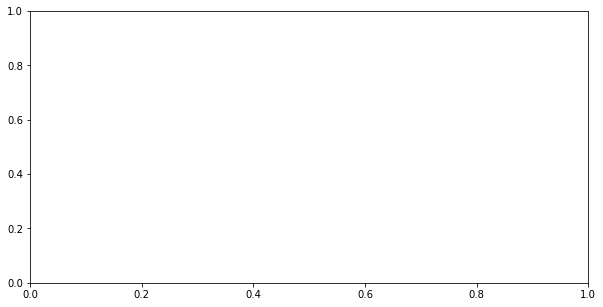

In [26]:
#(YKR_ID, Comparison, Comparisontype, grid, output_folder)
YI = 5878087
vehicles = ['car', 'public transport']
timedistance = 'time'
fp = r'data/MetropAccess_YKR_grid_EurefFIN.shp'
ykr_grid = gpd.read_file(fp)
op = 'data'

#does not work :()
ComparisonTool(YKR_ID = YI, Comparison = vehicles, Comparisontype = timedistance, grid = ykr_grid, output_folder = op)

In [12]:
#define function for the filefinder
def FileFinder(YKR_ID, foldername):
    """finds a list of travel time matrix files based on a single YKR_ID or a list of YKR_ID values from a specified input folder"""
    
    #Make assertions that given IDs are in the form of integer, string or list of integers or strings and the foldername is string
    assert type(YKR_ID) == str or type(YKR_ID) == int or type(YKR_ID) == builtins.list, 'The given variable must be a string, integer or list'
    if type(YKR_ID) == builtins.list:
        for index in YKR_ID:
            assert type(index) == str or type(index) == int, 'The variables in a given list need to be string or integer'
        
    assert type(foldername) == str, 'The foldername needs to be a string'
    
    #If the given IDs are not a list, create a list for the single ID for smoother handling
    if type(YKR_ID) != builtins.list:
        copy = YKR_ID
        YKR_ID = []
        YKR_ID.append(copy)

    #create a list with text files from given folder and its subfolders (recursive=true)
    list = glob.glob(foldername + '/**/*.txt',recursive=True)
    filenumbers = []
    for i in list:
        split = i.split('_')
        split = split[2].split('.')
        filenumbers.append(split[0])
       
    #Go through the given files and see which match with given YKR_IDs        
    filenames = []
    index = 0
    for i in filenumbers:
        file = 'TravelTimes_to_' + i + '.txt'
        index = index + 1
        print('processing file', file,'... Progress: ', str(index), '/', str(len(filenumbers)))
        #go through given YKR IDs to find if they match with the file names.
        #If a match is found, the file number is removed to make sure it's not added two times to the output list
        for j in YKR_ID:
            if str(j) == i:
                filename = 'TravelTimes_to_' + str(j) + '.txt'
                filenames.append(filename)
                YKR_ID.remove(j)
    if len(filenames) < 1:
        print('No files found with given YKR ID(s)')
        
    #Collect full filepaths for the output from the list created in the first steps. Print the amount of files found       
    output = []
    for i in filenames:
        for j in list:
            if i in j:
                output.append(j)
                list.remove(j)
    print('FileFinder completed! Found ' + str(len(output)) + ' files with the given YKR IDs!')
    return output



#define function for tablejoiner
def TableJoiner(Matrix_txt, grid):
    """creates a layer from the given text table or a list of tables by joining the file with given YKR grid geodataframe
    where from_id in Matrix file corresponds to YKR_ID in the Shapefile"""
    
    #Create asssertions that the Matrix_txt variable is a string or a list of strings and the grid variable is a geodataframe
    assert type(Matrix_txt) == str or type(Matrix_txt) == __builtins__.list, 'The given variable must be a string or list'
    if type(Matrix_txt) == __builtins__.list:
        for index in Matrix_txt:
            assert type(index) == str, 'The variables in a given list need to be in string format'
            
    assert isinstance(grid, gpd.GeoDataFrame), 'grid variable needs to be a geodataframe'
    
    #matrix_txt variable is a single string
    if type(Matrix_txt) == str:
        #read file from filepath, use ; as separator, use specific columns and remove values less than 0
        data = pd.read_csv(Matrix_txt, sep=';', na_values=-1)
        data = data.loc[data['walk_t'] >= 0]
        data = data.loc[data['pt_r_t'] >= 0]
        data = data.loc[data['car_r_t'] >= 0]
        #data = data.loc[data['bike_s_t'] >= 0]
        
        data = data.loc[data['walk_d'] >= 0]
        data = data.loc[data['car_r_d'] >= 0]
        data = data.loc[data['pt_r_d'] >= 0]
        #data = data.loc[data['bike_t'] >= 0]
        
        #merge data with YKR grid file
        output = ykr_grid.merge(data, left_on='YKR_ID', right_on='from_id')
        
        #create filepath for the joined table and save it
        split = Matrix_txt.split('_')
        split = split[2].split('.')
        out_fp = 'data/' + split[0] + '.shp'
        output.to_file(out_fp)
    
    #matrix_txt variable is a list of strings
    if type(Matrix_txt) == builtins.list:
        #for each filepath from the list of strings, read file, use ; as separator and use specific columns, remove values less than 0
        for index in Matrix_txt:
            data = pd.read_csv(index, sep=';', na_values=-1)
            data = data.loc[data['walk_t'] >= 0]
            data = data.loc[data['pt_r_t'] >= 0]
            data = data.loc[data['car_r_t'] >= 0]
            
            #merge data with YKR grid file
            output = ykr_grid.merge(data, left_on='YKR_ID', right_on='from_id')
            
            #create filepath for the joined table and save it
            split = index.split('_')
            split = split[2].split('.')
            out_fp = 'data/' + split[0] + '.shp'
            output.to_file(out_fp)
    
            

            
            
#define function for the Visualizer
def Visualizer(YKR_ID, Travelmode, Traveltype, Maptype, output_folder, grid):
    """Visualizes the travel times of a single YKR_ID or a list of YKR_IDs based on travel times by 'car',
    'public transport', 'walking' or 'biking'. The output maps can be either 'static' or 'interactive'
    static maps are saved in the specified folder as images and interactive maps are saved as html files"""
    
    #assert that the types are following:
    #YKR_ID = string, integer or list of strings or integers
    assert type(YKR_ID) == str or type(YKR_ID) == int or type(YKR_ID) == builtins.list, 'YKR_ID variable must be a string, integer or a list of strings or integers'
    if type(YKR_ID) == builtins.list:
        for index in YKR_ID:
            assert type(index) == str or type(index) == int, 'The variables in a given list need to be in string or integer format'
    
    #Travelmode needs to be a string and can either be car, public transport, walking or biking
    assert type(Travelmode) == str, 'Travel mode needs to be in string format. Choose car, publictransport, walking or biking'
    assert Travelmode == 'car' or Travelmode == 'public transport' or Travelmode == 'walking' or Travelmode == 'biking', 'Travel mode needs to be either car, public transport, walking or biking'
    
    #Traveltype = single string of two options
    assert type(Traveltype) == str, 'Comparison type variable needs to be a string. Choose either "time" or "distance"'
    assert Traveltype == 'time' or Traveltype == 'distance', 'Comparison type needs to be either "time" or "distance"'
    
    #maptype needs to be a string and can either be static or interactive
    assert type(Maptype) == str, 'Map type needs to be in string format. Choose static of interactive map'
    assert Maptype == 'static' or Maptype == 'interactive', 'Map type needs to be either static or interactive'
    
    #output folder needs to be a string
    assert type(output_folder) == str, 'output folder needs to be in string format.'
    
    #grid variable needs to be a geodataframe
    assert isinstance(grid, gpd.GeoDataFrame), 'grid variable needs to be a geodataframe'
    
    #This step can either be done outside the visualizer function or within it. I chose to add it within the function
    Filelist = FileFinder(YKR_ID = YKR_ID, foldername = 'data')
    TableJoiner(Filelist, grid)
    
    #if the filelist is empty, no travel time data could be found
    assert len(Filelist) >= 1, 'Could not find travel time data from the data folder. Check the input formats and data folder of Filefinder function'
    
    #For each row in the filelist, read the datafile and classify the travel modes in it
    for index in Filelist:
        split = Filelist[0].split('_')
        split = split[2].split('.')
        filename = 'data/' + split[0] + '.shp'
        map_data = gpd.read_file(filename)
        
        if Traveltype == 'time':
            
            #Create a function to classify.  I also created a list for the bins for a neat code
            bins = [5,10,15,20,25,30,35,40,45,50,55,60]
            classifier = mapclassify.UserDefined.make(bins=bins)
            #Apply function to both columns and create 2 new columns
            #At first i had trouble with this but then I noticed to apply the double square brackets
            map_data['car_r_t_cl'] = map_data[['car_r_t']].apply(classifier)
            map_data['pt_r_t_cl'] = map_data[['pt_r_t']].apply(classifier)
            map_data['walk_t_cl'] = map_data[['walk_t']].apply(classifier)
            #map_data['bike_s_t_cl'] = map_data[['bike_s_t']].apply(classifier)
        
        else:
            #Create a function to classify.  I also created a list for the bins for a neat code
            bins = [500,3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33000]
            classifier = mapclassify.UserDefined.make(bins=bins)
            map_data['car_r_d_cl'] = map_data[['car_r_d']].apply(classifier)
            map_data['pt_r_d_cl'] = map_data[['pt_r_d']].apply(classifier)
            map_data['walk_d_cl'] = map_data[['walk_d']].apply(classifier)
            #map_data['bike_s_d_cl'] = map_data[['bike_d_t']].apply(classifier)
        
        #for static maps
        if Maptype == 'static':
            
            # Define output filename and use it when saving the file:
            if Traveltype == 'time':
                output_file = output_folder + '/' + split[0] + '_accessibility_by_' + Travelmode.strip() + 'in_minutes.png'
            else:
                output_file = output_folder + '/' + split[0] + '_accessibility_by_' + Travelmode.strip() + 'in_meters.png'
            
            #Create the subplot and define names for the two figures for neat code
            fig, ax = plt.subplots(figsize=(10,5))
            
            #plot the map
            
            if Travelmode == 'car':
                if Traveltype == 'time':
                    plot = map_data.plot(column = 'car_r_t_cl', ax=ax, cmap='RdYlBu')
                else:
                    plot = map_data.plot(column = 'car_r_d_cl', ax=ax, cmap='RdYlBu')
                    
            if Travelmode == 'public transport':
                if Traveltype == 'time':
                    plot = map_data.plot(column = 'pt_r_t_cl', ax=ax, cmap='RdYlBu')
                else:
                    plot = map_data.plot(column = 'pt_r_d_cl', ax=ax, cmap='RdYlBu')
                
            if Travelmode == 'walking':
                if Traveltype == 'time':
                    plot = map_data.plot(column = 'walk_t_cl', ax=ax, cmap='RdYlBu')
                else:
                    plot = map_data.plot(column = 'walk_d_cl', ax=ax, cmap='RdYlBu')
                
            #if Travelmode == 'biking':
                #if Traveltype = 'time':
                    #plot = map_data.plot(column = 'bike_s_t_cl', ax=ax, cmap='RdYlBu')
                #else:
                    #plot = map_data.plot(column = 'bike_s_d_cl', ax=ax, cmap='RdYlBu')
        
            #apply titles and squeeze the layout
            ax.title.set_text(split[0] + ' accessibility by ' + Travelmode)
            plt.tight_layout()
            plt.savefig(output_file)
            
        if Maptype == 'interactive':
            #define geoid for folium mapping
            map_data['geoid'] = map_data.index.astype(str)
            #creating interactive map
            map = folium.Map(location=[60.11, 24.56], tiles = 'cartodbpositron', zoom_start=10, control_scale=True)
            if Traveltype == 'time':
                output_file = output_folder + '/' + split[0] + '_accessibility_by_' + Travelmode.strip() + 'in_minutes.html'
            else:
                output_file = output_folder + '/' + split[0] + '_accessibility_by_' + Travelmode.strip() + 'in_meters.html'

            #car
            if Travelmode == 'car':
                if Traveltype == 'time':
                    folium.Choropleth(geo_data = map_data,
                                      data = map_data,
                                      columns = ['geoid','car_r_t_cl'],
                                      key_on = 'feature.id',
                                      fill_color = 'RdYlBu',
                                      line_color = 'white',
                                      line_weight = 0,
                                      legend_name = split[0] + ' accessibility by ' + Travelmode + ' in minutes').add_to(map)
                else:
                    folium.Choropleth(geo_data = map_data,
                                      data = map_data,
                                      columns = ['geoid','car_r_d_cl'],
                                      key_on = 'feature.id',
                                      fill_color = 'RdYlBu',
                                      line_color = 'white',
                                      line_weight = 0,
                                      legend_name = split[0] + ' accessibility by ' + Travelmode + ' in meters').add_to(map)
            #public transport    
            if Travelmode == 'public transport':
                if Traveltype == 'time':
                    folium.Choropleth(geo_data = map_data,
                                      data = map_data,
                                      columns = ['geoid','pt_r_t_cl'],
                                      key_on = 'feature.id',
                                      fill_color = 'RdYlBu',
                                      line_color = 'white',
                                      line_weight = 0,
                                      legend_name = split[0] + ' accessibility by ' + Travelmode + ' in minutes').add_to(map)
                else:
                    folium.Choropleth(geo_data = map_data,
                                      data = map_data,
                                      columns = ['geoid','pt_r_d_cl'],
                                      key_on = 'feature.id',
                                      fill_color = 'RdYlBu',
                                      line_color = 'white',
                                      line_weight = 0,
                                      legend_name = split[0] + ' accessibility by ' + Travelmode + ' in meters').add_to(map)
            #walking
            if Travelmode == 'walking':
                if Traveltype == 'time':
                    folium.Choropleth(geo_data = map_data,
                                      data = map_data,
                                      columns = ['geoid','walk_t_cl'],
                                      key_on = 'feature.id',
                                      fill_color = 'RdYlBu',
                                      line_color = 'white',
                                      line_weight = 0,
                                      legend_name = split[0] + ' accessibility by ' + Travelmode + ' in minutes').add_to(map)
                else:
                    folium.Choropleth(geo_data = map_data,
                                      data = map_data,
                                      columns = ['geoid','walk_d_cl'],
                                      key_on = 'feature.id',
                                      fill_color = 'RdYlBu',
                                      line_color = 'white',
                                      line_weight = 0,
                                      legend_name = split[0] + ' accessibility by ' + Travelmode + ' in meters').add_to(map)
            #biking
            #if Travelmode == 'biking':
                #if Traveltype == 'time':
                    #folium.Choropleth(geo_data = map_data,
                                      #data = map_data,
                                      #columns = ['geoid','bike_s_t_cl'],
                                      #key_on = 'feature.id',
                                      #fill_color = 'RdYlBu',
                                      #line_color = 'white',
                                      #line_weight = 0,
                                      #legend_name = split[0] + ' accessibility by ' + Travelmode + ' in minutes').add_to(map)
                #else:
                    #folium.Choropleth(geo_data = map_data,
                                      #data = map_data,
                                      #columns = ['geoid','bike_d_cl'],
                                      #key_on = 'feature.id',
                                      #fill_color = 'RdYlBu',
                                      #line_color = 'white',
                                      #line_weight = 0,
                                      #legend_name = split[0] + ' accessibility by ' + Travelmode + ' in meters').add_to(map)
            #save the html file
            map.save(output_file)